Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-53-1677e76cb790>:24: RuntimeWarning: divide by zero encountered in divide
  depths = (f * B) / disparity


[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]
[[-168.75 -168.75 -168.75 ... -168.75 -168.75 -168.75]
 [-168.75 -168.75 -168.75 ... -168.75 -168.75 -168.75]
 [-168.75 -168.75 -168.75 ... -168.75 -168.75 -168.75]
 ...
 [-168.75 -168.75 -168.75 ... -168.75 -168.75 -168.75]
 [-168.75 -168.75 -168.75 ... -168.75 -168.75 -168.75]
 [-168.75 -168.75 -168.75 ... -168.75 -168.75 -168.75]]


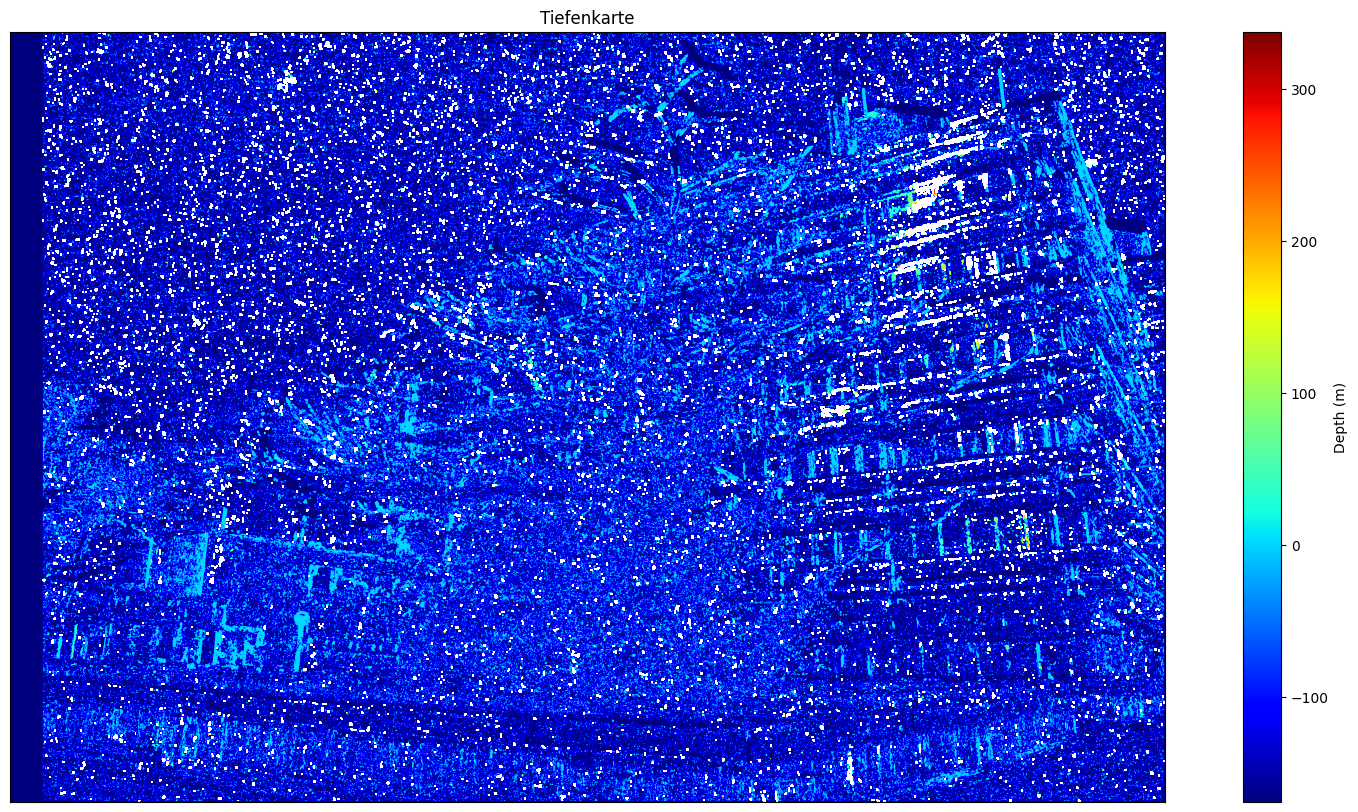

In [ ]:
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
drive.mount('/content/drive')


# Lade die beiden Bilder
imgL = cv2.imread('/content/drive/My Drive/Baum_L.JPG', 0)
imgR = cv2.imread('/content/drive/My Drive/Baum_R.JPG', 0)

imgL2 = cv2.imread('/content/drive/My Drive/Gang_L.JPG', 0)
imgR2 = cv2.imread('/content/drive/My Drive/Gang_R.JPG', 0)
#cv2_imshow(imgL)
#cv2_imshow(imgR)


stereo = cv2.StereoBM_create(numDisparities=96, blockSize=7)
disparity = stereo.compute(imgL,imgR)

f = 18
B = 150
depths = (f * B) / disparity

print(disparity)
print(depths)

plt.figure(figsize=(20, 10))
#plt.imshow(disparity, cmap='gray')  # Benutze 'gray' für ein Graustufen-Farbschema
plt.imshow(depths, cmap='jet')  # Verwenden Sie 'jet' für eine farbcodierte Darstellung der Tiefen
plt.colorbar(label='Depth (m)')  # Fügen Sie eine Farbskala für die Tiefen hinzu
plt.title('Tiefenkarte')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Abdrift openCV Histogram

img = imgL
img = np.dstack([img, img])  # Stack img with itself along the third dimension
print('Input image shape:', img.shape)

n_channels = img.shape[2]
channels = list(range(n_channels))
sizes = [256,] * n_channels
ranges = [0, 256] * n_channels
hist = cv2.calcHist([img], channels, None, sizes, ranges)  # Calculate histogram
print('Output histogram shape:', hist.shape)

Input image shape: (2304, 3456, 2)
Output histogram shape: (256, 256)


<ipython-input-39-8a3bef57e03b>:15: RuntimeWarning: divide by zero encountered in divide
  depth_map = (baseline * focal_length) / disparity2
<ipython-input-39-8a3bef57e03b>:23: RuntimeWarning: invalid value encountered in cast
  depth2_color = cv2.applyColorMap((depth2_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)


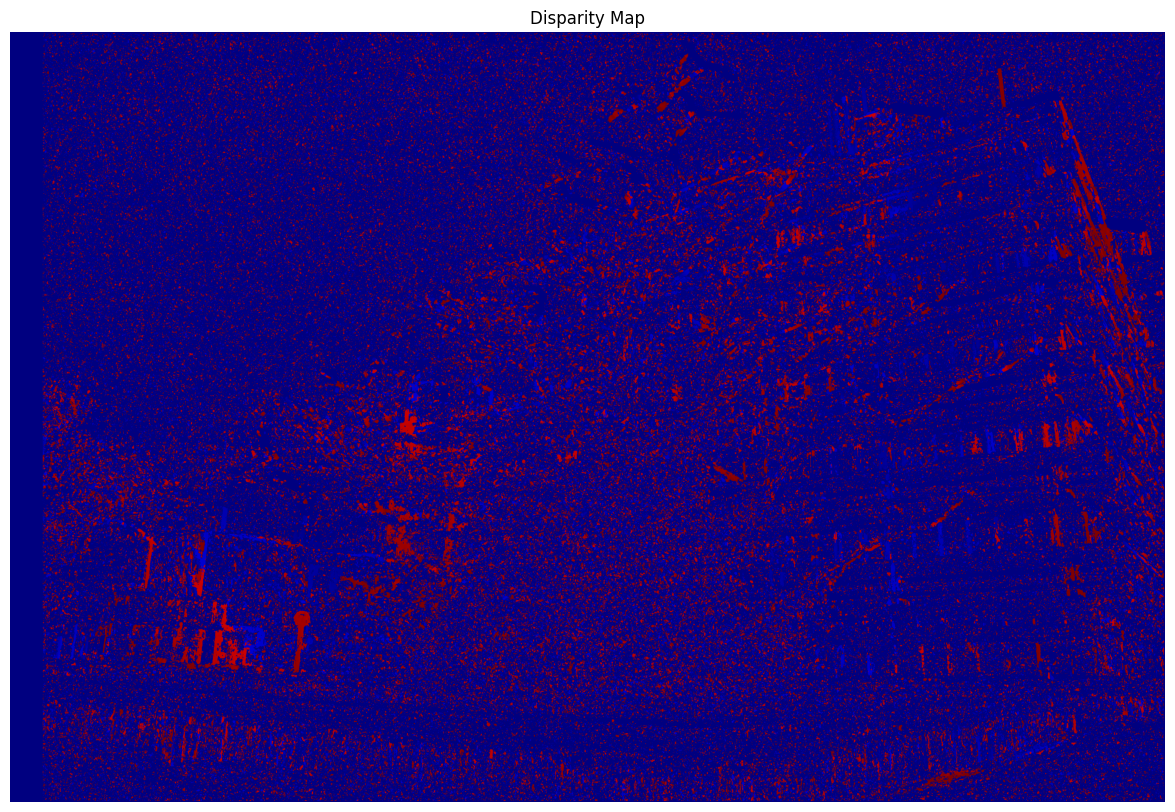

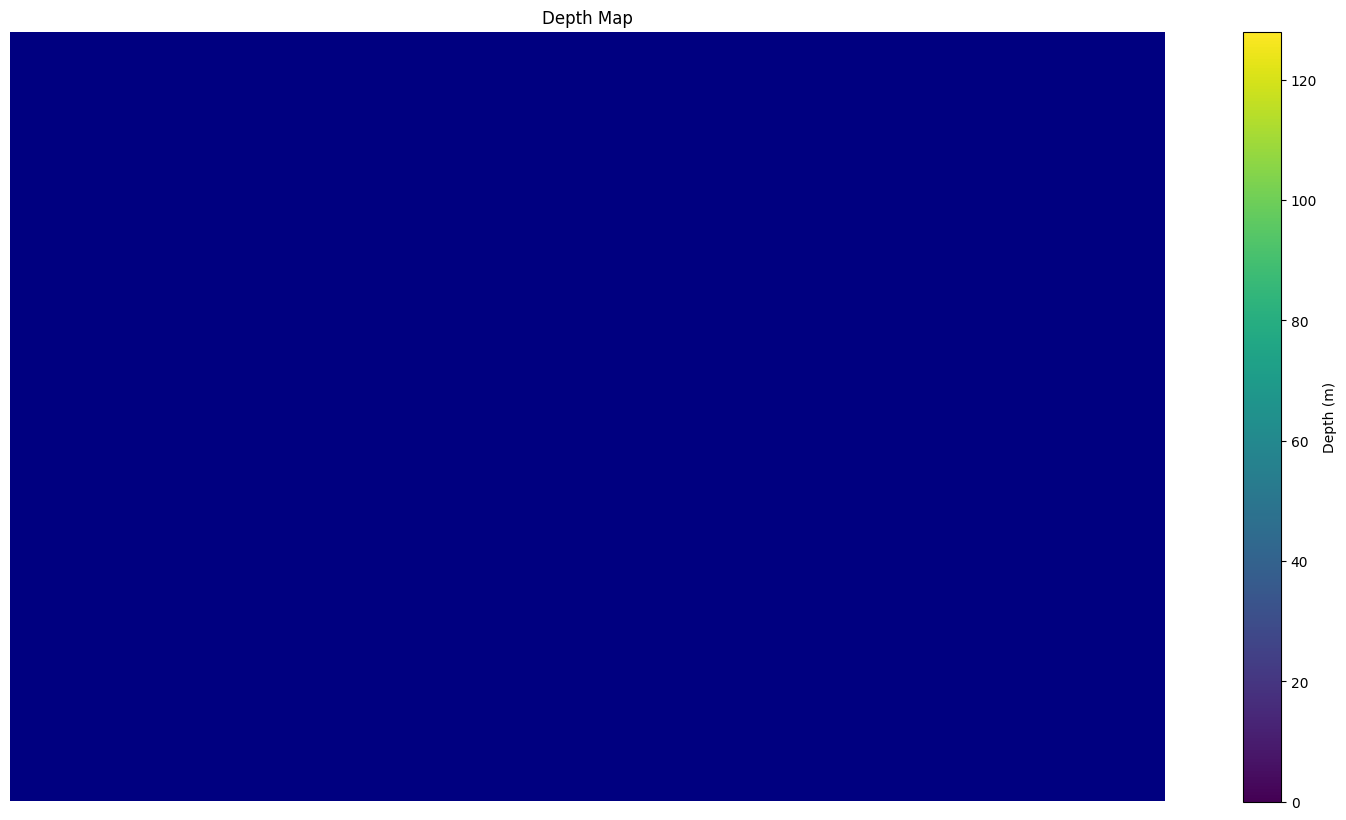

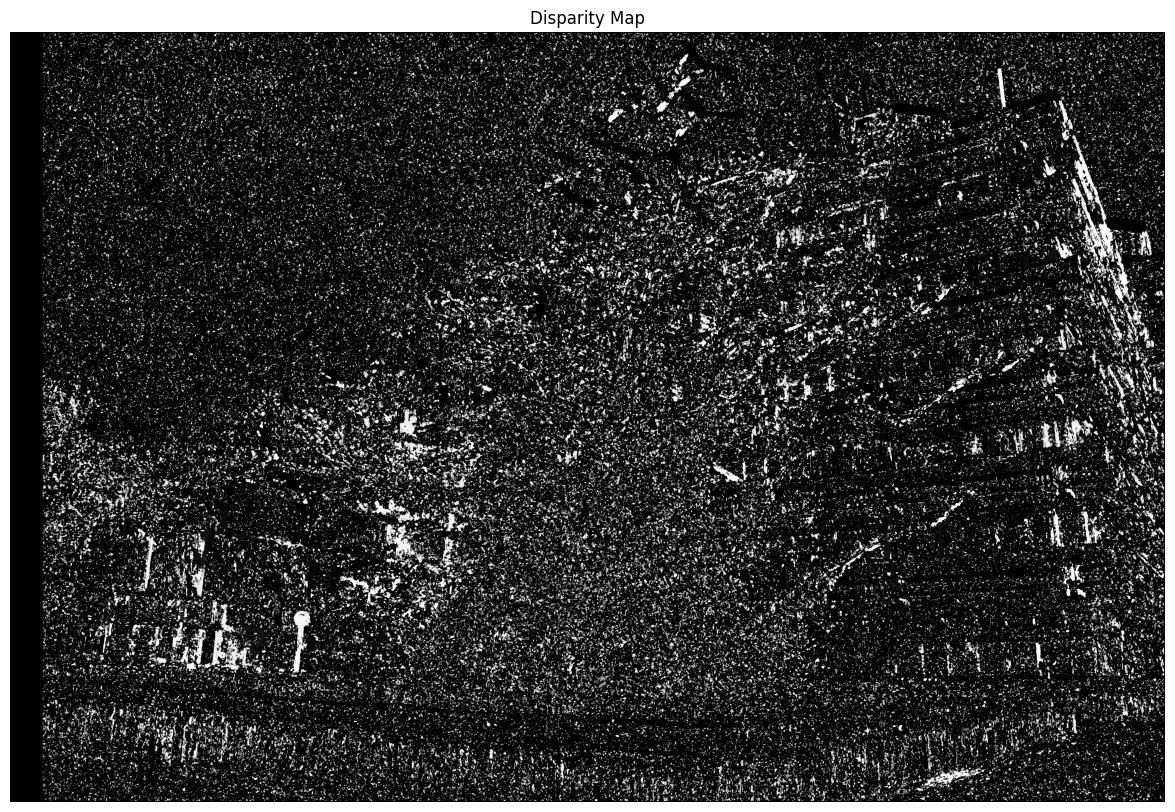

In [ ]:
# Normalisieren der Disparitätskarte für die Anzeige
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity2 = stereo.compute(imgL,imgR)

# Baseline (Abstand zwischen den Kameras) und Brennweite der Kamera
baseline = 150  # Beispielwert, bitte anpassen
focal_length = 18  # Beispielwert, bitte anpassen


min_disp = disparity.min()
max_disp = disparity.max()
disparity2 = np.uint8(255 * (disparity - min_disp) / (max_disp - min_disp))

# Konvertieren der Disparitätskarte in eine Tiefenkarte
depth_map = (baseline * focal_length) / disparity2

# normalisieren
disparity2_normalized = cv2.normalize(disparity2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
depth2_normalized = cv2.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Umwandeln der Disparitätskarte in eine Farbkarte
disparity2_color = cv2.applyColorMap(disparity2_normalized, cv2.COLORMAP_JET)
depth2_color = cv2.applyColorMap((depth2_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)


# Anzeigen der Disparitätskarte mit Matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(disparity2_color, cv2.COLOR_BGR2RGB))
plt.title('Disparity Map')
plt.axis('off')
plt.show()

# Tiefe
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(depth2_color, cv2.COLOR_BGR2RGB))
plt.colorbar(label='Depth (m)')
plt.title('Depth Map')
plt.axis('off')
plt.show()

#plt.figure(figsize=(20, 10))
#plt.imshow(disparity2_normalized, cmap='gray')
#plt.title('Disparity Map')
#plt.axis('off')
#plt.show()

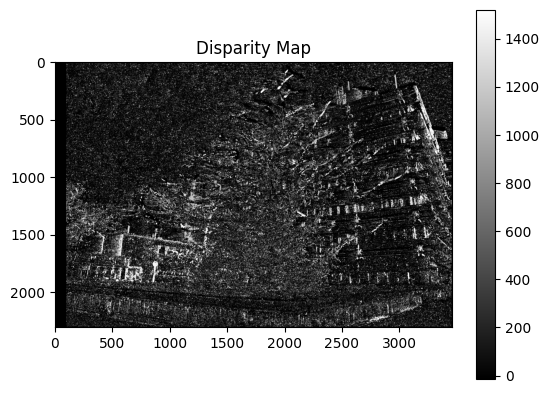

In [ ]:
#Semi-Global Block Matching (SGBM)

#stereoSGBM = cv2.StereoSGBM_create(minDisparity=0, numDisparities=16, blockSize=15)
window_size = 7
min_disp = 16
nDispFactor = 14
num_disp = 16*nDispFactor-min_disp

stereoSGBM = cv2.StereoSGBM_create(minDisparity = min_disp,
                              numDisparities = num_disp,
                              blockSize = window_size,
                              P1 = 8 * 3 * window_size**2,
                              P2 = 32 * 3 * window_size**2,
                              disp12MaxDiff = 1,
                              uniquenessRatio = 15,
                              speckleWindowSize = 0,
                              speckleRange = 2,
                              preFilterCap = 63,
                              mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)

disparitySGBM = stereo.compute(imgL,imgR)

#plt.figure(figsize=(20, 10))
plt.imshow(disparitySGBM, 'gray')
plt.title('Disparity Map')
plt.colorbar()
plt.show()

<ipython-input-50-e0ec728a027f>:5: RuntimeWarning: divide by zero encountered in divide
  depthSGBMCol = (baseline * focal_length) / disparitySGBMCol
<ipython-input-50-e0ec728a027f>:7: RuntimeWarning: invalid value encountered in cast
  depthSGBMCol_col = cv2.applyColorMap((depthSGBMCol_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)


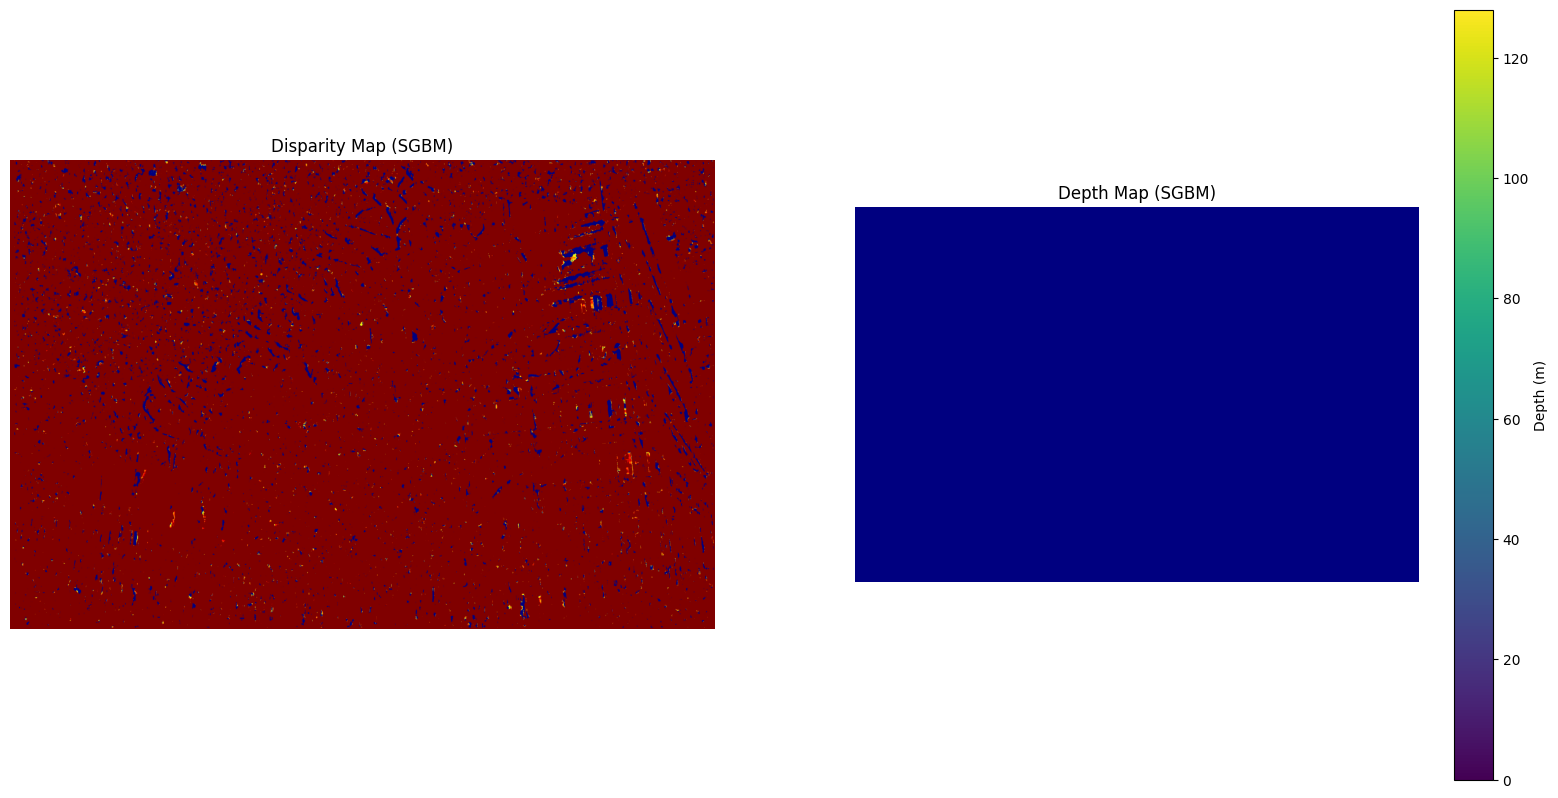

In [ ]:
stereoSGBMCol = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparitySGBMCol = stereo.compute(imgL,imgR)
disparitySGBMCol_color = cv2.applyColorMap(cv2.convertScaleAbs(disparitySGBMCol, alpha=255 / 16), cv2.COLORMAP_JET)

depthSGBMCol = (baseline * focal_length) / disparitySGBMCol
depthSGBMCol_normalized = cv2.normalize(depthSGBMCol, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
depthSGBMCol_col = cv2.applyColorMap((depthSGBMCol_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(disparitySGBMCol_color, cv2.COLOR_BGR2RGB))
plt.title('Disparity Map (SGBM)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(depthSGBMCol_col, cv2.COLOR_BGR2RGB))
plt.colorbar(label='Depth (m)')
plt.title('Depth Map (SGBM)')
plt.axis('off')

plt.show()